In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/Users/zhouji/Documents/github/gempy")

from gempy.core.tensor.tensorflow_graph_test import TFGraph
import tensorflow as tf
import pandas as pd
import gempy as gp
from gempy.assets.geophysics import GravityPreprocessing
import tensorflow_probability as tfp
import timeit
import scipy.stats as stats
import math
tfb = tfp.bijectors
tfd=tfp.distributions
psd_kernels = tfp.math.psd_kernels

def Plot_2D_scaler_field(grid,scaler_field):
    G = grid[np.where(grid[:,1] == [grid[-1][1]])[0]]
    S = scaler_field.numpy()[np.where(grid[:,1] == [grid[0][1]])[0]]
    XX = G[:,0].reshape([50,50])
    ZZ = G[:,2].reshape([50,50])
    S = S.reshape([50,50])
    plt.contour(XX,ZZ,S)


geo_data = gp.create_data([0, 1000, 0, 1000, 0, 1000], resolution=[50, 50, 50],
                          path_o="/Users/zhouji/Documents/github/gempy/notebooks/data/input_data/jan_models/model2_orientations.csv",
                          path_i="/Users/zhouji/Documents/github/gempy/notebooks/data/input_data/jan_models/model2_surface_points.csv")
gp.map_series_to_surfaces(geo_data, {"Strat_Series": (
    'rock2', 'rock1'), "Basement_Series": ('basement')})

geo_data.add_surface_values([2.61,3.1,2.92])

## Gravity test
## ---------
grav_res = 20
X = np.linspace(0, 1000, grav_res)
Y = np.linspace(0, 1000, grav_res)
Z= 300
xyz= np.meshgrid(X, Y, Z)
xy_ravel = np.vstack(list(map(np.ravel, xyz))).T


geo_data.set_centered_grid(xy_ravel,  resolution = [10, 10, 15], radius=5000)
interpolator = geo_data.interpolator
dtype = interpolator.additional_data.options.df.loc['values', 'dtype']

dips_position, dip_angles, azimuth, polarity, surface_points_coord, fault_drift, grid, values_properties = interpolator.get_python_input_block()[
    0:-3]

g = GravityPreprocessing(geo_data.grid.centered_grid)
tz = g.set_tz_kernel()

len_rest_form = interpolator.additional_data.structure_data.df.loc[
    'values', 'len surfaces surface_points']-1
Range = interpolator.additional_data.kriging_data.df.loc['values', 'range']
C_o = interpolator.additional_data.kriging_data.df.loc['values', '$C_o$']
rescale_factor = interpolator.additional_data.rescaling_data.df.loc[
    'values', 'rescaling factor']
nugget_effect_grad = np.cast[dtype](
    np.tile(interpolator.orientations.df['smooth'], 3))
nugget_effect_scalar = np.cast[interpolator.dtype](
    interpolator.surface_points.df['smooth'])

surface_points_coord = tf.Variable(surface_points_coord,dtype = tf.float64)

dips_position = tf.convert_to_tensor(dips_position)
dip_angles = tf.convert_to_tensor(dip_angles)
azimuth = tf.convert_to_tensor(azimuth)
polarity = tf.convert_to_tensor(polarity)
surface_points_coord = tf.convert_to_tensor(surface_points_coord)
fault_drift = tf.convert_to_tensor(fault_drift)
grid = tf.convert_to_tensor(grid)
values_properties = tf.convert_to_tensor(values_properties)
len_rest_form = tf.convert_to_tensor(len_rest_form)
Range = tf.convert_to_tensor(Range,tf.float64)
C_o = tf.convert_to_tensor(C_o)
nugget_effect_grad = tf.convert_to_tensor(nugget_effect_grad)
nugget_effect_scalar = tf.convert_to_tensor(nugget_effect_scalar)
rescale_factor = tf.convert_to_tensor(rescale_factor,tf.float64)
TFG = TFGraph(dips_position, dip_angles, azimuth,
  polarity, surface_points_coord, fault_drift,
  grid, values_properties, len_rest_form, Range,
  C_o, nugget_effect_scalar, nugget_effect_grad,
  rescale_factor)


Z_x = TFG.scalar_field()
scalar_field_at_surface_points = TFG.get_scalar_field_at_surface_points(Z_x)
formations_block = TFG.export_formation_block(Z_x,scalar_field_at_surface_points,values_properties)

lg_0 = interpolator.grid.get_grid_args('centered')[0]
lg_1 = interpolator.grid.get_grid_args('centered')[1]

densities = formations_block[1][lg_0:lg_1]

grav = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)

Data = grav

Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [2]:
def constant64(i):
    return(tf.constant(i,dtype = tf.float64))

#### Data mutation test

In [3]:
start = timeit.default_timer()
TFG.surface_points_all.assign(TFG.surface_points_all+tf.random.uniform(TFG.surface_points_all.shape,minval=-10., maxval=10.,dtype = tf.float64)/rescale_factor)
Z_x = TFG.scalar_field()
end = timeit.default_timer()
print(end - start)
# Z_x = new

2.047830831999999


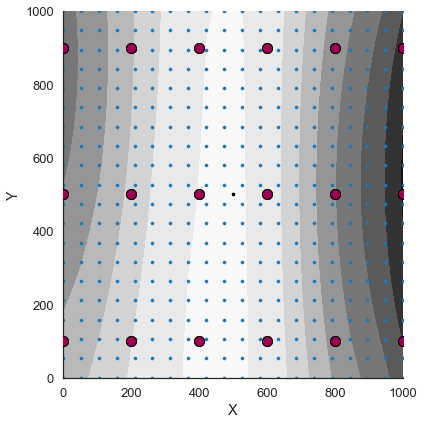

In [3]:
scalar_field_at_surface_points = TFG.get_scalar_field_at_surface_points(Z_x)
formations_block = TFG.export_formation_block(Z_x,scalar_field_at_surface_points,values_properties)

densities = formations_block[1][lg_0:lg_1]

grav = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)

grav = tf.reshape(grav,[20,20])
### Plot gravity response
xx,yy = np.meshgrid(X,Y)

gp.plot.plot_data(geo_data, direction='z',)
ax = plt.gca()
ax.scatter(xy_ravel[:,0], xy_ravel[:, 1], s=10,zorder=1)
ax.contourf(xx,yy,grav,zorder=-1)

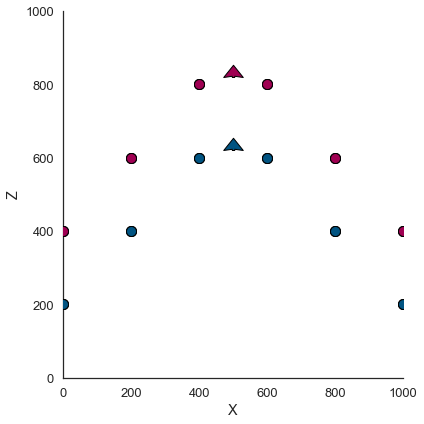

In [30]:
gp.plot.plot_data(geo_data, direction='y',)

In [41]:
mu = TFG.surface_points_all[:,2]+tf.random.uniform([tf.shape(TFG.surface_points_all)[0]],minval=-10., maxval=10.,dtype = tf.float64)/rescale_factor

In [42]:
mu

<tf.Tensor: shape=(36,), dtype=float64, numpy=
array([0.34859126, 0.34230458, 0.34555205, 0.54944463, 0.54458417,
       0.54153319, 0.44833514, 0.44883149, 0.44076218, 0.44618285,
       0.4438519 , 0.44486877, 0.54843903, 0.54425179, 0.54092825,
       0.34993918, 0.34601262, 0.34759102, 0.44299354, 0.44356691,
       0.44753794, 0.4444913 , 0.44643758, 0.44139206, 0.6468732 ,
       0.64095235, 0.64634486, 0.5451166 , 0.54808625, 0.54665738,
       0.64043192, 0.64370593, 0.64405994, 0.54909408, 0.54646181,
       0.54582052])>

In [48]:
TFG.surface_points_all[:,2].assign(mu)
Z_x = TFG.scalar_field()
scalar_field_at_surface_points = TFG.get_scalar_field_at_surface_points(Z_x)
formations_block = TFG.export_formation_block(Z_x,scalar_field_at_surface_points,values_properties)

lg_0 = interpolator.grid.get_grid_args('centered')[0]
lg_1 = interpolator.grid.get_grid_args('centered')[1]

densities = formations_block[1][lg_0:lg_1]

grav = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)

In [49]:
# grav = tf.reshape(grav,[20,20])
# ### Plot gravity response
# xx,yy = np.meshgrid(X,Y)
# gp.plot.plot_data(geo_data, direction='z',)
# ax = plt.gca()
# ax.scatter(xy_ravel[:,0], xy_ravel[:, 1], s=10,zorder=1)
# ax.contourf(xx,yy,grav,zorder=-1)

# Bayesian inference
### Define ground truth data

In [8]:
grav = tf.reshape(grav,[20,20])

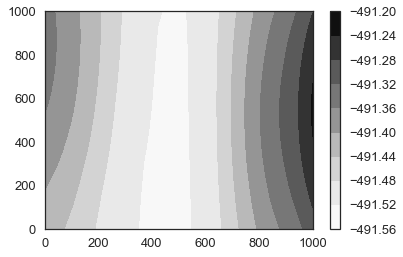

In [9]:
plt.contourf(xx,yy,grav,zorder=-1)
plt.colorbar()

In [16]:
Number_para = TFG.surface_points_all.shape[0]
obs_N = xy_ravel.shape[0]
number_burnin = 30
number_sample = 100

In [5]:
mu_prior = 750.*tf.ones([Number_para],dtype = tf.float64)
cov_prior = 30000.*tf.eye(Number_para,dtype= tf.float64)

sig_e = tf.constant(0.03, dtype=tf.float64) # standard deviation
cov = sig_e**2.*tf.eye(obs_N,dtype = tf.float64)

In [6]:
mu = TFG.surface_points_all[:,2]

In [7]:
mvn_prior = tfd.MultivariateNormalTriL(
        loc = mu_prior,
        scale_tril=tf.linalg.cholesky(cov_prior))

TFG.surface_points_all[:,2].assign(mu)
Z_x = TFG.scalar_field()
scalar_field_at_surface_points = TFG.get_scalar_field_at_surface_points(Z_x)
formations_block = TFG.export_formation_block(Z_x,scalar_field_at_surface_points,values_properties)

lg_0 = interpolator.grid.get_grid_args('centered')[0]
lg_1 = interpolator.grid.get_grid_args('centered')[1]

densities = formations_block[1][lg_0:lg_1]

Gm_ = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)

mvn_likelihood = tfd.MultivariateNormalTriL(
            loc = Gm_,
            scale_tril= tf.linalg.cholesky(cov))
print(mvn_prior.log_prob(mu))
print(mvn_likelihood.log_prob(Data))

tf.Tensor(-555.6974976613715, shape=(), dtype=float64)
tf.Tensor(1035.0477456461238, shape=(), dtype=float64)


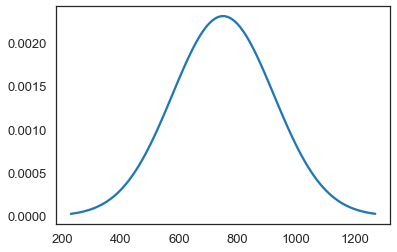

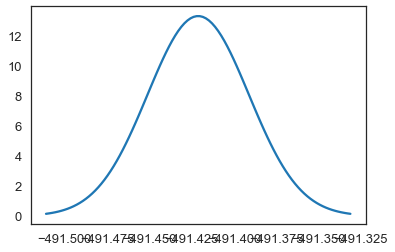

In [8]:
mu0= mu_prior[0]
variance = cov_prior[0,0]
sigma = math.sqrt(variance)
x = np.linspace(mu0- 3*sigma, mu0+ 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu0, sigma))
plt.show()

mu0= Gm_[0]
variance = cov[0,0]
sigma = math.sqrt(variance)
x = np.linspace(mu0- 3*sigma, mu0+ 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu0, sigma))
plt.show()

In [11]:
@tf.function
def joint_log_post(mu):
    # define random variables prior
    mvn_prior = tfd.MultivariateNormalTriL(
            loc = mu_prior,
            scale_tril=tf.linalg.cholesky(cov_prior))

    TFG.surface_points_all[:,2].assign(mu)
    Z_x = TFG.scalar_field()
    scalar_field_at_surface_points = TFG.get_scalar_field_at_surface_points(Z_x)

    formations_block = TFG.export_formation_block(Z_x,scalar_field_at_surface_points,values_properties)

    lg_0 = interpolator.grid.get_grid_args('centered')[0]
    lg_1 = interpolator.grid.get_grid_args('centered')[1]

    densities = formations_block[1][lg_0:lg_1]

    Gm_ = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)

    mvn_likelihood = tfd.MultivariateNormalTriL(
                loc = Gm_,
                scale_tril= tf.linalg.cholesky(cov))
    # return the posterior probability
    return (mvn_prior.log_prob(mu)
            +mvn_likelihood.log_prob(Data))


In [29]:
joint_log_post(mu)

<tf.Tensor: shape=(), dtype=float64, numpy=479.3502479847523>

In [17]:
num_results = number_sample
burnin = number_burnin

start = timeit.default_timer()
initial_chain_state = [
    500 * tf.ones([Number_para], dtype=tf.float64, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_post(*args)

def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

dtype = np.float64

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=1, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

end = timeit.default_timer()
print(start-end)


/Users/zhouji/anaconda3/envs/gempy/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [26]:
1000*0.08/60

1.3333333333333333

In [24]:
accept_index = np.where(accepted==True)
accepted_samples_RMH = samples[accept_index]

In [25]:
accepted_samples_RMH

array([[[500.21171922],
        [497.05958986],
        [497.13085777],
        [493.51052738],
        [498.05986426],
        [502.83129307],
        [500.92565759],
        [507.46963975],
        [503.40470921],
        [495.48397419],
        [502.25742875],
        [503.66480541],
        [503.61042944],
        [493.14167373],
        [496.62486179],
        [497.21738553],
        [500.72129723],
        [499.96663827],
        [508.25306826],
        [498.57219882],
        [503.13251507],
        [500.26527168],
        [491.24037119],
        [502.25517103],
        [500.97796162],
        [494.55171486],
        [501.14784012],
        [507.52002936],
        [491.61692322],
        [494.15195748],
        [503.13671741],
        [499.51708409],
        [496.30198316],
        [495.13592541],
        [494.48800924],
        [488.04363299]],

       [[501.98981377],
        [497.08872167],
        [496.64852673],
        [493.98353394],
        [497.35021967],
        [503.0

In [28]:
8*60/50

9.6

In [9]:
surface_points_coord = tf.Variable(surface_points_coord,dtype = tf.float64)

with tf.GradientTape() as t:
    TFG = TFGraph(dips_position, dip_angles, azimuth,
      polarity, surface_points_coord, fault_drift,
      grid, values_properties, len_rest_form, Range,
      C_o, nugget_effect_scalar, nugget_effect_grad,
      rescale_factor)
    t.watch(surface_points_coord)
    

    grid_val = TFG.x_to_interpolate(grid)
    weights = TFG.solve_kriging()

    tiled_weights = TFG.extend_dual_kriging(weights, grid_val.shape[0])

    sigma_0_grad = TFG.contribution_gradient_interface(grid_val, tiled_weights)
    sigma_0_interf = TFG.contribution_interface(grid_val, tiled_weights)
    f_0 = TFG.contribution_universal_drift(grid_val,weights)
    Z_x = TFG.scalar_field()
    scalar_field_at_surface_points = TFG.get_scalar_field_at_surface_points(Z_x)
    formations_block = TFG.export_formation_block(Z_x,scalar_field_at_surface_points,values_properties)

    lg_0 = tf.constant(interpolator.grid.get_grid_args('centered')[0])
    lg_1 = tf.constant(interpolator.grid.get_grid_args('centered')[1])
    densities = formations_block[1][lg_0:lg_1]

    grav = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)
grad = t.gradient(grav,surface_points_coord)
print(grad)

TypeError: x_to_interpolate() missing 2 required positional arguments: 'ref_layer_points' and 'rest_layer_points'

In [ ]:
lg_0 = interpolator.grid.get_grid_args('centered')[0]
lg_1 = interpolator.grid.get_grid_args('centered')[1]
densities = formations_block[1][lg_0:lg_1]

grav = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)

In [6]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/Users/zhouji/Documents/github/gempy")

from gempy.core.tensor.tensorflow_graph_test import TFGraph
import tensorflow as tf
import pandas as pd
import gempy as gp
from gempy.assets.geophysics import GravityPreprocessing

def Plot_2D_scaler_field(grid,scaler_field):
    G = grid[np.where(grid[:,1] == [grid[-1][1]])[0]]
    S = scaler_field.numpy()[np.where(grid[:,1] == [grid[0][1]])[0]]
    XX = G[:,0].reshape([50,50])
    ZZ = G[:,2].reshape([50,50])
    S = S.reshape([50,50])
    plt.contour(XX,ZZ,S)


geo_data = gp.create_data([0, 1000, 0, 1000, 0, 1000], resolution=[50, 50, 50],
                          path_o="/Users/zhouji/Documents/github/gempy/notebooks/data/input_data/jan_models/model2_orientations.csv",
                          path_i="/Users/zhouji/Documents/github/gempy/notebooks/data/input_data/jan_models/model2_surface_points.csv")
gp.map_series_to_surfaces(geo_data, {"Strat_Series": (
    'rock2', 'rock1'), "Basement_Series": ('basement')})

geo_data.add_surface_values([2.61,3.1,2.92])

## Gravity test
## ---------
# grav_res = 20
# X = np.linspace(0, 1000, grav_res)
# Y = np.linspace(0, 1000, grav_res)
# Z= 300
# xyz= np.meshgrid(X, Y, Z)
# xy_ravel = np.vstack(list(map(np.ravel, xyz))).T


# geo_data.set_centered_grid(xy_ravel,  resolution = [10, 10, 15], radius=5000)
interpolator = geo_data.interpolator
dtype = interpolator.additional_data.options.df.loc['values', 'dtype']

dips_position, dip_angles, azimuth, polarity, surface_points_coord, fault_drift, grid, values_properties = interpolator.get_python_input_block()[
    0:-3]

# g = GravityPreprocessing(geo_data.grid.centered_grid)
# tz = g.set_tz_kernel()

len_rest_form = interpolator.additional_data.structure_data.df.loc[
    'values', 'len surfaces surface_points']-1
Range = interpolator.additional_data.kriging_data.df.loc['values', 'range']
C_o = interpolator.additional_data.kriging_data.df.loc['values', '$C_o$']
rescale_factor = interpolator.additional_data.rescaling_data.df.loc[
    'values', 'rescaling factor']
nugget_effect_grad = np.cast[dtype](
    np.tile(interpolator.orientations.df['smooth'], 3))
nugget_effect_scalar = np.cast[interpolator.dtype](
    interpolator.surface_points.df['smooth'])

surface_points_coord = tf.Variable(surface_points_coord,dtype = tf.float64)

dips_position = tf.convert_to_tensor(dips_position)
dip_angles = tf.convert_to_tensor(dip_angles)
azimuth = tf.convert_to_tensor(azimuth)
polarity = tf.convert_to_tensor(polarity)
surface_points_coord = tf.convert_to_tensor(surface_points_coord)
fault_drift = tf.convert_to_tensor(fault_drift)
grid = tf.convert_to_tensor(grid)
values_properties = tf.convert_to_tensor(values_properties)
len_rest_form = tf.convert_to_tensor(len_rest_form)
Range = tf.convert_to_tensor(Range,tf.float64)
C_o = tf.convert_to_tensor(C_o)
nugget_effect_grad = tf.convert_to_tensor(nugget_effect_grad)
nugget_effect_scalar = tf.convert_to_tensor(nugget_effect_scalar)
rescale_factor = tf.convert_to_tensor(rescale_factor,tf.float64)
TFG = TFGraph(dips_position, dip_angles, azimuth,
  polarity, surface_points_coord, fault_drift,
  grid, values_properties, len_rest_form, Range,
  C_o, nugget_effect_scalar, nugget_effect_grad,
  rescale_factor)


Z_x = TFG.scalar_field()

Active grids: ['regular']
tracing sqd
tracing sqd
tracing sqd
tracing sqd
tracing sqd
tracing sqd
tracing sqd
tracing sqd
tracing sqd
tracing sqd
tracing contribution inter
executing sqd
executing sqd
executing sqd
executing sqd
executing sqd
executing sqd
executing contribution inter
executing sqd
executing sqd
executing sqd
executing sqd


In [8]:
TFG.scalar_field()

executing sqd
executing sqd
executing sqd
executing sqd
executing sqd
executing sqd
executing contribution inter
executing sqd
executing sqd
executing sqd
executing sqd


<tf.Tensor: shape=(125068,), dtype=float64, numpy=
array([0.3058228 , 0.31166632, 0.31674513, ..., 0.30266602, 0.30266602,
       0.30266602])>

In [ ]:
TFG.ref_layer_points.shape

In [ ]:
TFG.dips_position_all_tiled

In [ ]:
surface_points_coord = tf.Variable(surface_points_coord,dtype = tf.float64)

with tf.GradientTape() as t:
    t.watch(TFG.surface_points_all)
    TFG = TFGraph(dips_position, dip_angles, azimuth,
          polarity, surface_points_coord, fault_drift,
          grid, values_properties, len_rest_form, Range,
          C_o, nugget_effect_scalar, nugget_effect_grad,
          rescale_factor)
    
grad = t.gradient(TFG.rest_layer_points,TFG.surface_points_all)

In [ ]:
@tf.function
def gravity():
    TFG = TFGraph(dips_position, dip_angles, azimuth,
      polarity, surface_points_coord, fault_drift,
      grid, values_properties, len_rest_form, Range,
      C_o, nugget_effect_scalar, nugget_effect_grad,
      rescale_factor)
    grid_val = TFG.x_to_interpolate(grid)

In [ ]:
class Pow(tf.Module):
    def __init__(self, exponent):
        super(Pow, self).__init__()
        self.exponent = tf.Variable(exponent, dtype = tf.float32, name='Pow/exponent')
        
    @tf.function
    def function1(self):
        return tf.constant(2.) ** self.exponenate
    
    @tf.function
    def function2(self):
        self.exponenate = self.exponent+1
        return self.function1()*10

In [ ]:
pow = Pow(3)

In [ ]:
pow.function2()

In [ ]:
pow.exponent.assign(4)
pow.function2()

In [ ]:
x_2 = tf.constant([[2,0],[0,3]])

In [ ]:
tf.reshape(x_2[:, 0], [tf.shape(x_2)[0], 1])